# Deep Neural Network from Scratch

## Notes:
- For more understanding BackProgation Algorithms
- Building normal neural network and optimize by Gradient Descent Batching (FULL)

## Define normal library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scratch.layers import Dense

## Implement Layer

In [126]:
# ---- Base Layer ----
class Layer:
    def forward(self, X):
        raise NotImplementedError

    def backward(self, grad):
        raise NotImplementedError

    def update(self, lr):
        # general no parameters to update
        return
    
class Activation(Layer):
    def __init__(self):
        self.mask = None # Store mask for backward pass

class ReLU(Activation):
    def __init__(self):
        super().__init__()
        
    def forward(self, X):
        self.mask = X > 0
        return X * self.mask

    def backward(self, dA):
        if self.mask is None:
            raise RuntimeError("ReLU backward called before forward")
        return dA * self.mask
    
class Linear(Activation):
    def __init__(self):
        super().__init__()
        
    def forward(self, X):
        return X

    def backward(self, dA):
        return dA

# ---- High Layers ----
class Dense(Layer):
    def __init__(self, input_dim, output_dim, seed=42, activation=ReLU()):
        # Initialize weights with random initialization, bias to zeros
        np.random.seed(seed)
        self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
        self.b = np.zeros((1, output_dim))
        # Store for backward pass
        self.cache = None # Store input
        self.activation = activation 
        self.dW = None
        self.db = None

    def forward(self, X):
        self.cache = X
        Z = X.dot(self.W) + self.b
        A = self.activation.forward(Z)
        return A

    def backward(self, dA):
        dZ = self.activation.backward(dA)
        X = self.cache
        m = X.shape[0]
        self.dW = X.T.dot(dZ) / m
        self.db = np.sum(dZ, axis=0, keepdims=True) / m
        return dZ.dot(self.W.T)

    def update(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db

## Implement Loss Function

In [127]:
class MSELoss:
    def loss_and_grad(self, y_pred, y_true):
        m = y_true.shape[0]
        loss = np.sum((y_pred - y_true) ** 2) / (2 * m)
        grad = (y_pred - y_true) / m
        return loss, grad

## Implement Deep Neural Networks for regression problem

1. Backpropogation algorithm, all define in train_step: forward pass -> backward pass -> update weights, biases
2. Structure: 
- Layer 1: Dense(6 in, 5 out) -> ReLU(5 in, 5 out)
- Layer 2: Dense(5 in, 1 out) -> output
- Summary output by loss function (MSE) -> backpropogation algorithm for update
- Training Loop
3. Early Stopping: 
- Get improvement by |Loss(parameters_(i)) - Loss(parameters_(i+1))|
- Check conditions stop training by compare to min_delta

In [128]:
class WineQualityNet():
    """Dense network for wine-quality regression with optional early stopping."""
    def __init__(self, input_dim: int = 6, lr: float = 0.001, early_stopping: bool = True, min_delta: float = 1e-3, seed: int = 42):
        np.random.seed(seed)
        self.fc1 = Dense(input_dim, 5, seed=seed, activation=ReLU())
        self.fc2 = Dense(5, 1, seed=seed + 10, activation=Linear())
        self.loss_fn = MSELoss()
        self.lr = lr
        self.early_stopping = early_stopping
        self.min_delta = min_delta

    def forward(self, X):
        out = self.fc1.forward(X)
        out = self.fc2.forward(out) # regression output
        return out

    def backward(self, grad):
        grad = self.fc2.backward(grad)
        grad = self.fc1.backward(grad)
        return grad

    def update(self):
        for layer in [self.fc1, self.fc2]:
            layer.update(self.lr)

    def train_step(self, X, y):
        if not hasattr(self, "loss_fn"):
            raise AttributeError("Module needs a loss function to perform train_step")
        logits = self.forward(X)
        loss, grad = self.loss_fn.loss_and_grad(logits, y)
        self.backward(grad)
        self.update()
        return loss

    def train(self, X, y, epochs: int = 50, verbose: bool = True, X_test=None, y_test=None):
        """Full-batch SGD with optional early stopping on training loss. Main tasks is save loss history and print progress."""
        loss_history = []
        test_history = [] if X_test is not None else None
        prev_metric = None
        y = y.reshape(-1, 1)
        if y_test is not None:
            y_test = y_test.reshape(-1, 1)
        for epoch in range(1, epochs + 1):
            loss = self.train_step(X, y)
            monitor = loss
            if X_test is not None and y_test is not None:
                preds_test = self.predict(X_test)
                test_loss, _ = self.loss_fn.loss_and_grad(preds_test, y_test)
                test_history.append(test_loss)
            improvement = np.nan if prev_metric is None else prev_metric - monitor
            if verbose:
                msg = f"Epoch {epoch}: train_loss={loss:.4f} monitor={monitor:.4f} improv={improvement:.5f}"
                if test_history is not None:
                    msg += f" test_loss={test_history[-1]:.4f}"
                print(msg)
            loss_history.append(loss)
            if self.early_stopping and prev_metric is not None and improvement < self.min_delta:
                if verbose:
                    print(f"Early stopping at epoch {epoch}")
                break
            prev_metric = monitor
        return loss_history, test_history

    def predict(self, X):
        return self.forward(X)

In [129]:
# Load raw wine quality data (red wine) 
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")
assert df.shape[1] == 12, "Expected 11 features + 1 target"
feature_cols = df.columns[:6]  # use first 6 features
target_col = "quality"
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
# use only 20% of the data, then split that subset 80/20 into train/test
subset_size = max(1, int(0.2 * len(df)))
df_small = df.iloc[:subset_size].copy()
split = int(0.8 * len(df_small))
train_df = df_small.iloc[:split].copy()
test_df = df_small.iloc[split:].copy()
# use raw values (no standardization)
X_train = train_df[feature_cols].to_numpy(dtype=np.float32)
y_train = train_df[target_col].to_numpy(dtype=np.float32)
X_test = test_df[feature_cols].to_numpy(dtype=np.float32)
y_test = test_df[target_col].to_numpy(dtype=np.float32)
print("Subset size", df_small.shape, "Train shape", X_train.shape, "Test shape", X_test.shape)

Subset size (319, 12) Train shape (255, 6) Test shape (64, 6)


In [130]:
def run_experiment(early_stopping: bool, label: str, epochs: int = 70):
    model = WineQualityNet(
        lr=0.5,
        early_stopping=early_stopping,
        min_delta=0.01,
        seed=40,
    )
    train_loss_raw, test_loss_raw = model.train(
        X_train,
        y_train,
        epochs=epochs,
        verbose=False,
        X_test=X_test,
        y_test=y_test,
    )
    train_loss = [2 * v for v in train_loss_raw]
    test_loss = [2 * v for v in test_loss_raw] if test_loss_raw is not None else None
    test_mse = test_loss[-1] if test_loss is not None else None
    print(f"{label}: epochs_run={len(train_loss)} final_train_loss={train_loss[-1]:.4f} test_mse={test_mse:.4f}")
    return train_loss, test_loss, test_mse

No ES: epochs_run=70 final_train_loss=2.2482 test_mse=2.7256
With ES: epochs_run=55 final_train_loss=2.1997 test_mse=2.2609


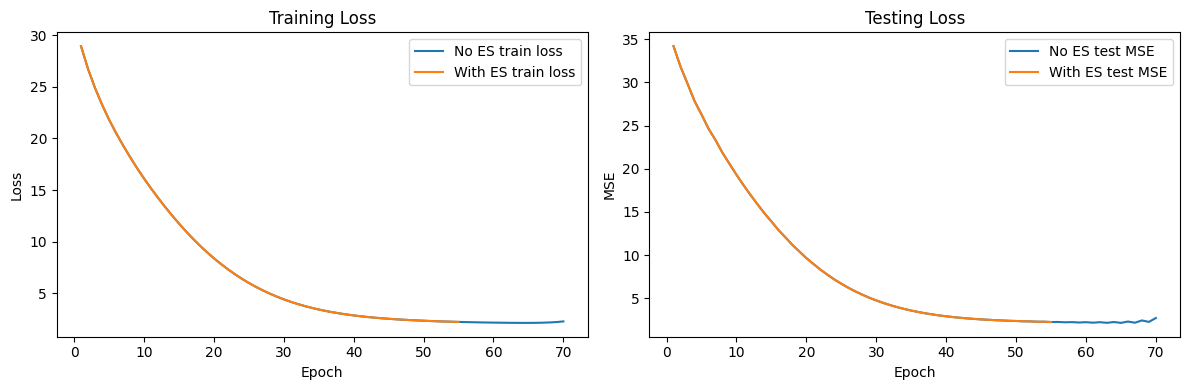

No ES test MSE: 2.7256
With ES test MSE: 2.2609


In [131]:
# Run without early stopping (full-batch)
train_loss_no_es, test_loss_no_es, test_mse_no_es = run_experiment(early_stopping=False, label="No ES")

# Run with early stopping (full-batch)
train_loss_es, test_loss_es, test_mse_es = run_experiment(early_stopping=True, label="With ES")

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Epoch indices start at 1 for readability
epochs_loss_no_es = range(1, len(train_loss_no_es) + 1)
epochs_loss_es = range(1, len(train_loss_es) + 1)

axes[0].plot(epochs_loss_no_es, train_loss_no_es, label="No ES train loss")
axes[0].plot(epochs_loss_es, train_loss_es, label="With ES train loss")
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot test MSE over epochs
epochs_test_no_es = range(1, len(test_loss_no_es) + 1) if test_loss_no_es is not None else []
epochs_test_es = range(1, len(test_loss_es) + 1) if test_loss_es is not None else []
if test_loss_no_es is not None:
    axes[1].plot(epochs_test_no_es, test_loss_no_es, label="No ES test MSE", color="#1f77b4")
if test_loss_es is not None:
    axes[1].plot(epochs_test_es, test_loss_es, label="With ES test MSE", color="#ff7f0e")
axes[1].set_title("Testing Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MSE")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"No ES test MSE: {test_mse_no_es:.4f}")
print(f"With ES test MSE: {test_mse_es:.4f}")